<p float="left">
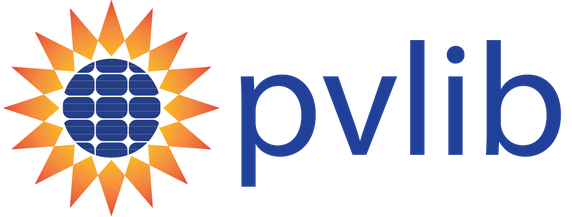
<img width="25"></img>
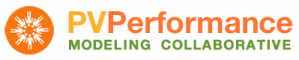
</p>

# SETO Webinar 3: pvlib python

This notebook is for "Part 3: Modeling Tools" in SETO's [Solar Data Bounty Prize](https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize) webinar series.  It demonstrates some examples of using [pvlib python](https://pvlib-python.readthedocs.io), an open-source PV modeling software toolbox, with monitoring data recorded at a PV power plant.

The power plant under study is [OEDI System 9068](https://openei.org/wiki/PVDAQ/Sites/SR_CO), a 4.7 MW utility-scale PV system in Colorado, United States.  System 9068 has two inverters powered by cadmium telluride (CdTe) PV modules mounted on single-axis trackers.

pvlib is a very flexible and powerful tool, making it useful in many areas of solar energy modeling and analysis.  Engineers, programmers, data scientists, analysts, and researchers across the field of PV use pvlib on a daily basis in their work.  This notebook focuses in on two demo use cases:

1) **System modeler**: Using system measurements to benchmark and compare the accuracy of different predictive models
2) **O&M analyst**: Using system models to help explain and identify unexpected features seen in monitoring data

To run this notebook yourself, you'll need:
- A python environment with `pvlib`, `matplotlib`, and a jupyter notebook interface installed
- The following files downloaded from this system's [OEDI data repository](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=pvdaq%2F2023-solar-data-prize%2F9068_OEDI%2F):
  * `9068_system_metadata.json`
  * `9068_irradiance_data.csv`
  * `9068_environment_data.csv`
  * `9068_ac_power_data.csv`

---

**Other helpful links:**

- pvlib's documentation: https://pvlib-python.readthedocs.io
- System 9068 pvlib model: https://pvlib-python.readthedocs.io/en/stable/gallery/system-models/plot_oedi_9068.html
- other pvlib tutorials: https://pvsc-python-tutorials.github.io/
- pvlib user discussion forum: https://groups.google.com/g/pvlib-python
- PV Performance Modeling Collaborative: https://pvpmc.sandia.gov
- 2023 Solar Data Bounty Prize: https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize

In [1]:
import pvlib

import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
print("This python environment has pvlib version:", pvlib.__version__)

This python environment has pvlib version: 0.10.3


In [3]:
with open('data/9068_system_metadata.json') as f:
    metadata = json.load(f)

metadata['Site']

{'site_id': 7213,
 'public_name': 's_SR_CO_1',
 'location': 'Kersey, CO',
 'us_region': 'West',
 'latitude': 40.3864,
 'longitude': -104.5512,
 'elevation(m)': 1407.0,
 'climate_type': 'Bsk'}

In [4]:
lat = metadata['Site']['latitude']
lon = metadata['Site']['longitude']

In [5]:
df_irr = pd.read_csv('data/9068_irradiance_data.csv', index_col=0, parse_dates=True)
df_env = pd.read_csv('data/9068_environment_data.csv', index_col=0, parse_dates=True)
df_inv = pd.read_csv('data/9068_ac_power_data.csv', index_col=0, parse_dates=True)

# Use case 1 (System modeler): Benchmarking temperature models

The temperature of a PV module affects its efficiency and is a key quantity when modeling or analyzing system performance.  However, there are many models available for predicting module temperature (see this list of models implemented in pvlib: https://pvlib-python.readthedocs.io/en/stable/reference/pv_modeling/temperature.html).  How can you tell which model is best for a particular system?

**Objective**: compare the accuracy of different temperature models by comparing their predictions with observed module temperature data.

First, let's see what temperature measurements are available to us in this dataset:

In [6]:
df_env.columns

Index(['weather_station_ambient_temperature_(c)_o_149727',
       'thermocouple_pad_1_back-of-module_temperature_1_(c)_o_149728',
       'thermocouple_pad_1_back-of-module_temperature_2_(c)_o_149729',
       'thermocouple_pad_2_back-of-module_temperature_1_(c)_o_149730',
       'thermocouple_pad_2_back-of-module_temperature_2_(c)_o_149731',
       'wind_sensor_max_wind_speed_(m/s)_o_149732',
       'wind_sensor_wind_direction_o_149733',
       'wind_sensor_wind_direction_fast_o_149735',
       'wind_sensor_wind_speed_(m/s)_o_149736',
       'wind_sensor_wind_speed_fast_(m/s)_o_149737',
       'wind_sensor_wind_speed_std._dev._(m/s)_o_149738',
       'inverter_module_1.1_temperature_ext_(c)_inv_149739',
       'inverter_module_1.1_temperature_r1_(c)_inv_149740',
       'inverter_module_1.1_temperature_r2_(c)_inv_149741',
       'inverter_module_1.1_temperature_r3_(c)_inv_149742',
       'inverter_module_1.1_temperature_s1_(c)_inv_149743',
       'inverter_module_1.1_temperature_s2_(c)_i

So one ambient temperature sensor (recording the temperature of the air) and four module temperature sensors.  Let's take a look at a day of data from those sensors to see what we're working with here:

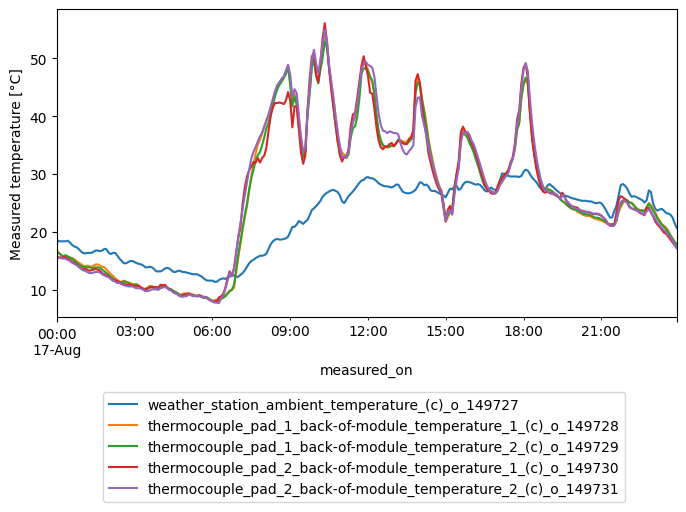

In [7]:
fig, axes = plt.subplots(figsize=(8, 4))

ambient_and_module_columns = [
    'weather_station_ambient_temperature_(c)_o_149727',
    'thermocouple_pad_1_back-of-module_temperature_1_(c)_o_149728',
    'thermocouple_pad_1_back-of-module_temperature_2_(c)_o_149729',
    'thermocouple_pad_2_back-of-module_temperature_1_(c)_o_149730',
    'thermocouple_pad_2_back-of-module_temperature_2_(c)_o_149731',
]

df_env.loc['2019-08-17', ambient_and_module_columns].plot(ax=axes)

axes.set_ylabel('Measured temperature [°C]')
axes.legend(loc=(0.075, -0.6))

Qualitatively, these temperature data seem reasonable, although this particular day looks like it had fairly variable weather.

Now, can we predict these module temperature values somehow?  Let's pick one model from pvlib just to start:

In [8]:
# documentation also available at: https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.temperature.faiman.html
pvlib.temperature.faiman?

Signature:
pvlib.temperature.faiman(
    poa_global,
    temp_air,
    wind_speed=1.0,
    u0=25.0,
    u1=6.84,
)
Docstring:
Calculate cell or module temperature using the Faiman model.

The Faiman model uses an empirical heat loss factor model [1]_ and is
adopted in the IEC 61853 standards [2]_ and [3]_.

Usage of this model in the IEC 61853 standard does not distinguish
between cell and module temperature.

Parameters
----------
poa_global : numeric
    Total incident irradiance [W/m^2].

temp_air : numeric
    Ambient dry bulb temperature [C].

wind_speed : numeric, default 1.0
    Wind speed in m/s measured at the same height for which the wind loss
    factor was determined.  The default value 1.0 m/s is the wind
    speed at module height used to determine NOCT. [m/s]

u0 : numeric, default 25.0
    Combined heat loss factor coefficient. The default value is one
    determined by Faiman for 7 silicon modules
    in the Negev desert on an open rack at 30.9° tilt.
    :math:`\left

So we need ambient temperature, POA irradiance, and wind speed.  Let's extract those from the dataframes we loaded earlier:

In [9]:
tamb = df_env['weather_station_ambient_temperature_(c)_o_149727']
wind_speed = df_env['wind_sensor_wind_speed_(m/s)_o_149736']
poa = df_irr['pyranometer_(class_a)_pad_2_poa_irradiance_temp_compensated_(w/m2)_o_149726']

# leaving the thermal coefficients at default values
tmod_faiman = pvlib.temperature.faiman(poa, tamb, wind_speed)

That was easy!  Let's see how the modeled module temperature values compare with the measurements:

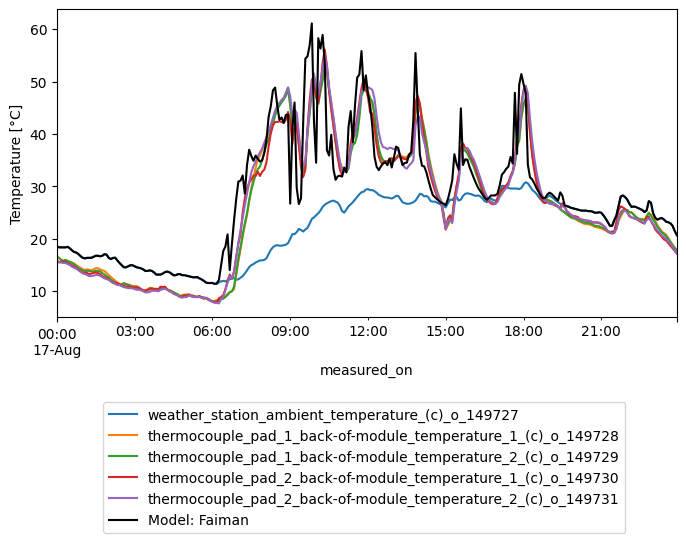

In [10]:
fig, axes = plt.subplots(figsize=(8, 4))

df_env.loc['2019-08-17', ambient_and_module_columns].plot(ax=axes)
tmod_faiman.loc['2019-08-17'].plot(ax=axes, c='k', label='Model: Faiman')

axes.set_ylabel('Temperature [°C]')
axes.legend(loc=(0.075, -0.7))

The general trends are correct, but it looks like the model isn't *quite* right; the modeled trace is "spikier" and seem to be changing too early.  Put another way, the observed temperature values tend to lag behind and have some inertia compared with the model.

This is a well-known effect.  The Faiman model is what's called a "steady-state" model in that it implicitly assumes that the weather inputs aren't changing very quickly over time.  On a highly variable day like this one, the problems with this assumption are clearly demonstrated.

So how can we fix this?  Let's use the Prilliman model to apply thermal transience to the model:

In [11]:
# check online docs page for parameter descriptions, or use the "?" feature like before
tmod_faiman_prilliman = pvlib.temperature.prilliman(tmod_faiman, wind_speed, unit_mass=16.6)

C:\Users\ksande\software\miniconda3\envs\dev\lib\site-packages\pvlib\temperature.py:1088: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator


Now let's compare with measurements again:

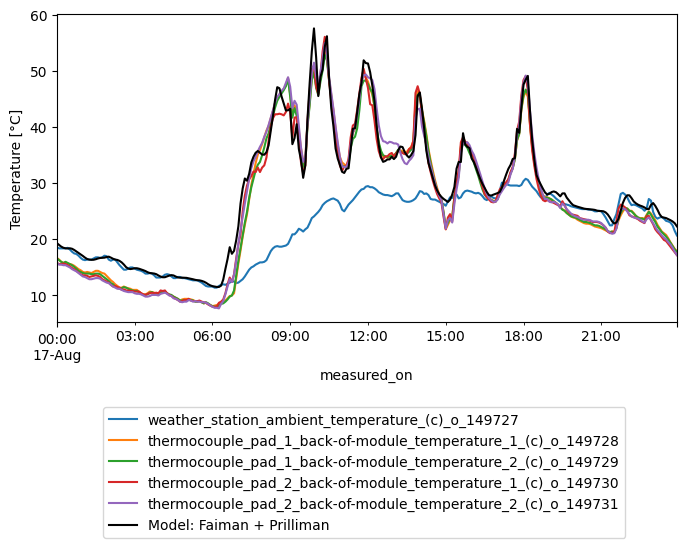

In [12]:
fig, axes = plt.subplots(figsize=(8, 4))

df_env.loc['2019-08-17', ambient_and_module_columns].plot(ax=axes)
tmod_faiman_prilliman.loc['2019-08-17'].plot(ax=axes, c='k', label='Model: Faiman + Prilliman')

axes.set_ylabel('Temperature [°C]')
axes.legend(loc=(0.075, -0.7))

A significant improvement!  The model is still not perfect, but for much of the day it falls within the spread of the measurements themselves.

Now, let's try out some other temperature models to see how they compare.  With pvlib, it's easy to bring several models together:

In [13]:
tmod_pvsyst = pvlib.temperature.pvsyst_cell(poa, tamb, wind_speed)

sapm_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
tmod_sapm = pvlib.temperature.sapm_cell(poa, tamb, wind_speed, **sapm_params)

In [14]:
# bundle all the modeled values into a dataframe for convenience
tmod_modeled = pd.DataFrame({
    'Faiman': tmod_faiman,
    'SAPM': tmod_sapm,
    'PVsyst': tmod_pvsyst,
    'Faiman + Prilliman': tmod_faiman_prilliman,
})

Now instead of just making plots, let's calculate some error statistics.  To do that, let's get a single basis of comparison to simplify things.  One way to do that is to take the median of the four temperature sensor readings:

In [15]:
tmod_observed = df_env[[
    'thermocouple_pad_1_back-of-module_temperature_1_(c)_o_149728',
    'thermocouple_pad_1_back-of-module_temperature_2_(c)_o_149729',
    'thermocouple_pad_2_back-of-module_temperature_1_(c)_o_149730'
]].median(axis=1)

In [16]:
# compare temperature values using the entire year of 2018
date_range = '2018'

# For this comparison, let's only consider times with irradiance above zero.
# In a real model comparison, more careful filtering should be done
mask = (poa.loc[date_range] > 0)

Finally, let's loop through our models, calculate error statistics, and visualize the comparison:

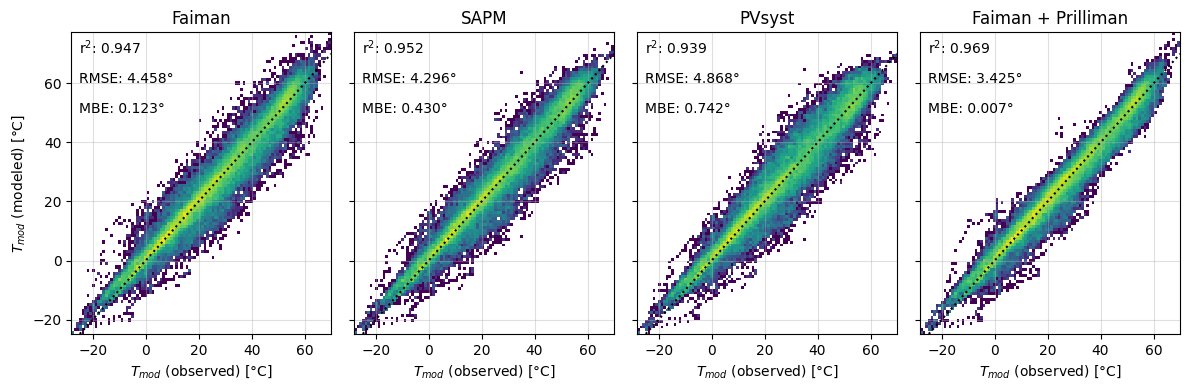

In [17]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
for col, ax in zip(tmod_modeled, axes.flatten()):
    x = tmod_observed.loc[date_range]
    y = tmod_modeled.loc[date_range, col]

    x = x[mask]
    y = y[mask]
    filt = x.notnull() & y.notnull()
    x = x[filt]
    y = y[filt]

    # calculate deviation statistics
    rmse = ((x - y)**2).mean()**0.5
    r2 = x.corr(y)**2
    mbe = (y - x).mean()

    # make density scatter plot for this model
    ax.hist2d(x, y, (100, 100), cmin=1, norm=LogNorm())
    ax.axline((0, 0), slope=1, c='k', ls=':')
    ax.grid(alpha=0.4)
    ax.set_xlabel('$T_{mod}$ (observed) [°C]')
    ax.set_title(col)

    ax.text(-25, 50, f'MBE: {mbe:0.3f}°')
    ax.text(-25, 60, f'RMSE: {rmse:0.3f}°')
    ax.text(-25, 70, f'r$^2$: {r2:0.3f}')

axes[0].set_ylabel('$T_{{mod}}$ (modeled) [°C]')
fig.tight_layout()

What have we achieved?

- use pvlib to use some monitoring quantities to predict another
- compare multiple models to see which one best recreates this system's measured values

# Use case 2 (O&M analyst): Investigating unexpected data features 

Performance analysts routinely inspect and analyze monitoring data to calculate performance metrics or investigate why a system may be underperforming.  However, system idiosyncrasies and sensor issues can create data features which are difficult to interpret.  In these tricky cases, pvlib can be a very useful tool to lend context and help understand what the data is telling you.

**Objective:** use pvlib to assist in explaining unexpected features in monitoring data.

A very useful visualization for performance analysis is a scatter plot of system output versus POA irradiance, so let's start there.  For this example we'll look at data for the month of January, 2018.

Text(0.5, 0, 'POA Irradiance [W/m$^2$]')

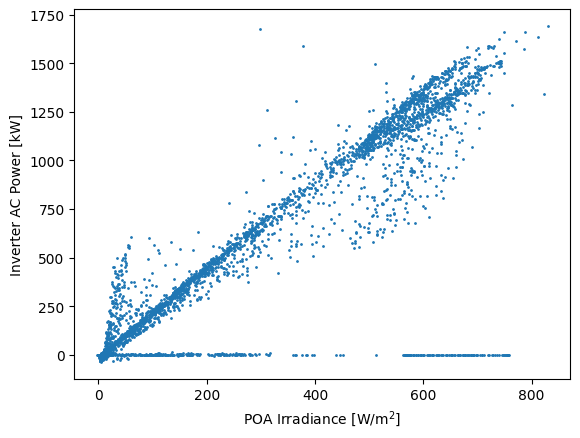

In [18]:
date = '2018-01'

poa = df_irr.loc[date, 'pyranometer_(class_a)_pad_2_poa_irradiance_temp_compensated_(w/m2)_o_149726'].tz_localize('US/Mountain')
power = df_inv.loc[date, 'inverter_1_ac_power_(kw)_inv_150143'].tz_localize('US/Mountain')

plt.scatter(poa, power, s=1)
plt.ylabel('Inverter AC Power [kW]')
plt.xlabel('POA Irradiance [W/m$^2$]')

Theoretically, system output should follow a mostly linear trend with POA irradiance, but here we see some strange features:
- a group of "impossible" points above the main trend at low irradiance where the inverter is seeming to produce far more power than would be expected for the irradiance level
- a cloud of points below the main trend where the inverter is seeming to produce less power than expected for the irradiance level

Of course there is also a group of points at nonzero irradiance but zero power; presumably these are from an inverter outage.

Let's take a look at the data in time series view to see if that tells us anything:

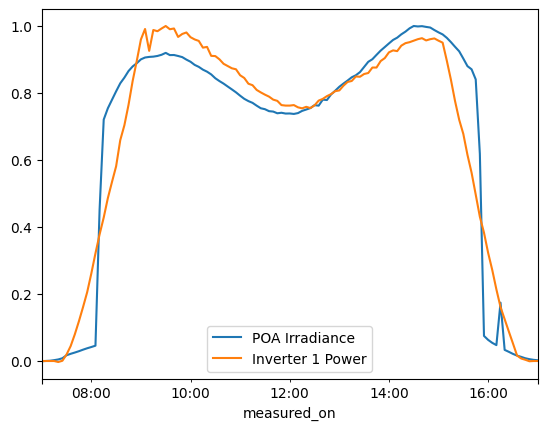

In [19]:
date = slice('2018-01-04 07:00', '2018-01-04 17:00')
poa_day = poa.loc[date]
power_day = df_inv.loc[date, 'inverter_1_ac_power_(kw)_inv_150143']

poa_day.divide(poa_day.max()).plot(label='POA Irradiance')
power_day.divide(power_day.max()).plot(label='Inverter 1 Power')
plt.legend()

Now we see a little more: irradiance seems too high on the shoulders of the day and suddenly too low at the edges.  The sudden drop-off suggests there might be some kind of sensor shading going on.  It could be external to the array, but notice that the shading seems roughly symmetrical in morning and evening...

Well, we know that this is a tracking CdTe system, which means it doesn't backtrack in the morning and evening.  Could this be somehow caused by row-to-row shading?  Let's use pvlib to calculate some helpful values:

In [20]:
# first, solar positions and hypothetical tracker rotation angles.
# Could use measured tracker positinos instead, but then would have to make sure the data aren't messed up.

sp = pvlib.solarposition.get_solarposition(poa.index, lat, lon)
tr = pvlib.tracking.singleaxis(sp.zenith, sp.azimuth, axis_azimuth=180, backtrack=False, max_angle=60)

In [21]:
# now, let's use pvlib to model row-to-row shading.  this function calculates a "shaded fraction",
# i.e. the fraction of a PV row's module area that is shaded by the row in front.
# note: we are using an "internal" pvlib function here, since a user-facing function
# for calculating shaded fraction hasn't been added yet.  We will include one in pvlib soon.

gcr = 0.347  # estimated from satellite imagery and module datasheet info
shaded_fraction = pvlib.bifacial.infinite_sheds._shaded_fraction(sp.zenith, sp.azimuth, tr.surface_tilt, tr.surface_azimuth, gcr)
shaded_fraction = pd.Series(shaded_fraction, index=poa.index)

With our calculated shaded fraction in hand, let's see what we can learn by comparing it with the pyranometer readings:

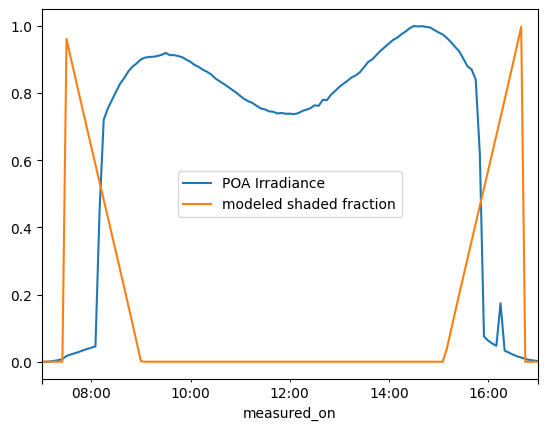

In [22]:
poa_day.divide(poa_day.max()).plot(label='POA Irradiance')
#power_day.divide(power_day.max()).plot(label='Inverter 1 Power')
shaded_fraction.loc[date].plot(label='modeled shaded fraction')
plt.legend()

It looks like the irradiance jump occurs right when the shaded fraction is 0.5!  Let's verify that:

In [23]:
sf_less_than_half = shaded_fraction < 0.5
sf_greater_than_half = shaded_fraction > 0.5

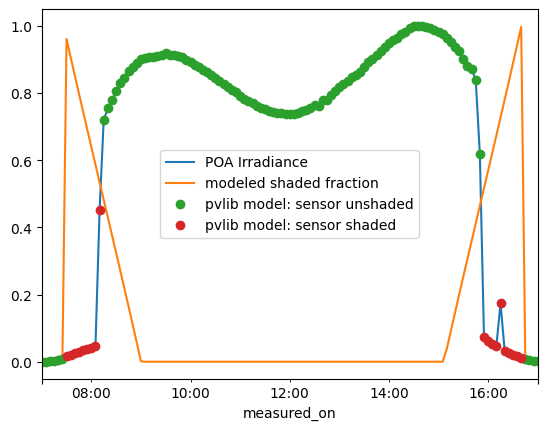

In [24]:
poa_day.divide(poa_day.max()).plot(label='POA Irradiance')
shaded_fraction.loc[date].plot(label='modeled shaded fraction')

aux = poa_day.divide(poa_day.max())
aux[sf_less_than_half.loc[date]].plot(ls='', marker='o', ms=6, label='pvlib model: sensor unshaded')
aux[sf_greater_than_half.loc[date]].plot(ls='', marker='o', ms=6, label='pvlib model: sensor shaded')
plt.legend()

From this, we can make the guess that this pyranometer is mounted on the tracker torque tube, so that when row-to-row shading reaches halfway up the tracker height, it starts to cover the pyranometer.

With that knowledge in hand, let's use our modeled shaded fraction to label values in the overall dataset:

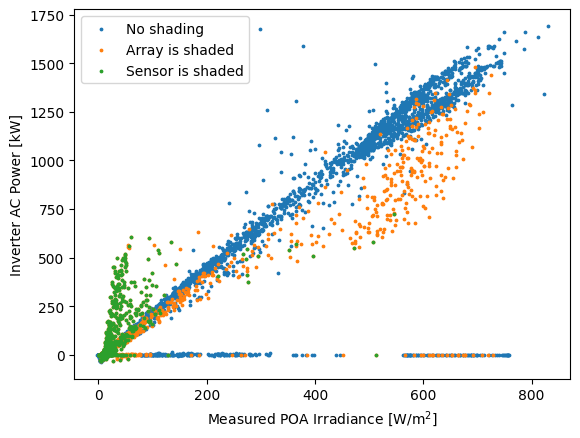

In [25]:
date = '2018-01'

filt_no_shade = shaded_fraction == 0
filt_array_shade = shaded_fraction > 0
filt_sensor_shade = shaded_fraction > 0.5

plt.scatter(poa[filt_no_shade], power[filt_no_shade], s=3, label='No shading')
plt.scatter(poa[filt_array_shade], power[filt_array_shade], s=3, label='Array is shaded')
plt.scatter(poa[filt_sensor_shade], power[filt_sensor_shade], s=3, label='Sensor is shaded')

plt.ylabel('Inverter AC Power [kW]')
plt.xlabel('Measured POA Irradiance [W/m$^2$]')
plt.legend()

Neat!  The poor-performing points correspond to times when some modules are shaded, but the pyranometer is not.  The "high-performing" cluster corresponds to times when the pyranometer is shaded too, and thus isn't a reliable source of the actual plane-of-array irradiance.

Note that we can use the modeled shaded fraction values to filter the dataset to only include unshaded times (useful for capacity tests, calculating performance ratios, etc):

Text(0.5, 0, 'Measured POA Irradiance [W/m$^2$]')

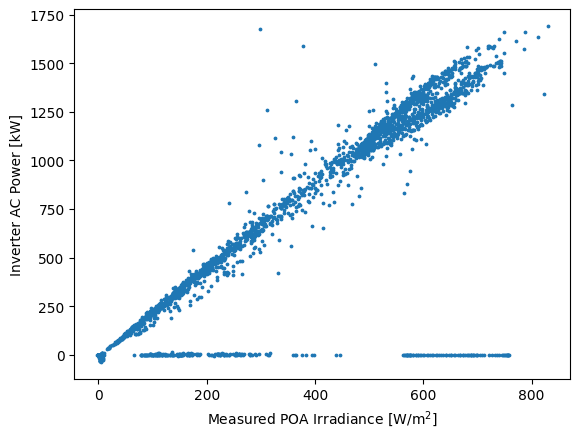

In [26]:
date = '2018-01'

plt.scatter(poa[filt_no_shade], power[filt_no_shade], s=3)

plt.ylabel('Inverter AC Power [kW]')
plt.xlabel('Measured POA Irradiance [W/m$^2$]')

Finally, just for completeness, let's make one combined figure that tells the whole story:

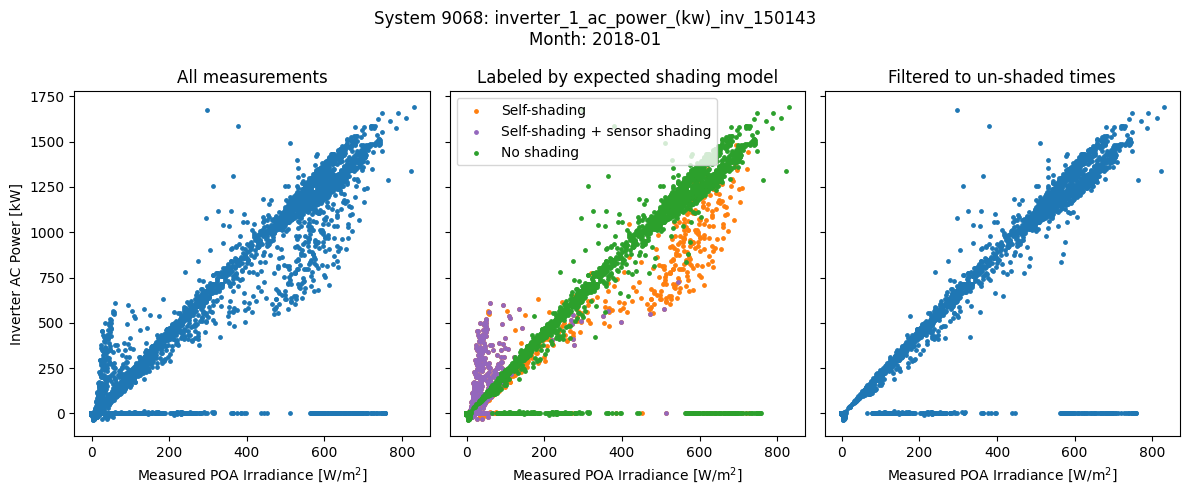

In [27]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 5))

axes[0].scatter(poa, power, s=6)
axes[0].set_title('All measurements')

axes[1].scatter(poa[filt_array_shade], power[filt_array_shade], s=6, c='tab:orange', label='Self-shading')
axes[1].scatter(poa[filt_sensor_shade], power[filt_sensor_shade], s=6, c='tab:purple', label='Self-shading + sensor shading')
axes[1].scatter(poa[filt_no_shade], power[filt_no_shade], s=6, c='tab:green', label='No shading')
axes[1].set_title(r'Labeled by expected shading model')
axes[1].legend()

axes[2].scatter(poa[filt_no_shade], power[filt_no_shade], s=6)
axes[2].set_title('Filtered to un-shaded times')

axes[0].set_ylabel('Inverter AC Power [kW]')
for ax in axes:
    ax.set_xlabel('Measured POA Irradiance [W/m$^2$]')

fig.suptitle(f'System 9068: {power.name}\nMonth: {date}')
fig.tight_layout()